In [1]:
from __future__ import print_function
from __future__ import absolute_import

In [2]:
import os
import tensorflow as tf

/home/sracela/miniconda3/envs/p2c/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sracela/miniconda3/envs/p2c/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sracela/miniconda3/envs/p2c/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sracela/miniconda3/envs/p2c/lib/python3.6/s

In [3]:
tf.enable_eager_execution()

In [4]:

tf.executing_eagerly()

True

### GPU

In [5]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

['/device:GPU:0']

In [6]:
tf.test.is_gpu_available()

True

In [7]:
tf.test.is_built_with_cuda()

True

In [8]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

# Dataset

In [9]:
from classes.Vocabulary import *
from classes.Utils import *

### Images and captions

Transformed images in training dataset to numpy arrays already provided in 

../datasets/web/training_features

Normalized pixel values and resized pictures 

In [10]:
# Store captions and image names in vectors
# Preprocess the images && Preprocess and tokenize the captions

input_path = '../datasets/android/training_features'
output_path = '../bin'

## Initialize Image model and load the pretrained Imagenet weights

### Dataset class

In [11]:
class Dataset:
    def __init__(self):
        self.input_shape = None
        self.output_size = None

        self.ids = []
        self.input_images = []
        self.total_sequences = []
        
        self.voc = Vocabulary()
        self.size = 0
    def load(self, path, generate_binary_sequences=False):
        print("Loading data...")
        for f in os.listdir(path):
            if f.find(".gui") != -1:
                gui = open("{}/{}".format(path, f), 'r')
                file_name = f[:f.find(".gui")]

                if os.path.isfile("{}/{}.png".format(path, file_name)):
                    img = Utils.get_preprocessed_img("{}/{}.png".format(path, file_name), IMAGE_SIZE)
                    self.append(file_name, gui, img)
                elif os.path.isfile("{}/{}.npz".format(path, file_name)):
                    img = np.load("{}/{}.npz".format(path, file_name))["features"]
                    self.append(file_name, gui, img)

        print("Generating sparse vectors...")
        self.voc.create_binary_representation()
        if generate_binary_sequences:
            self.total_sequences = self.binarize(self.total_sequences, self.voc)
        else:
            self.total_sequences = self.indexify(self.total_sequences, self.voc)
        
        self.size = len(self.ids)
        assert self.size == len(self.input_images) == len(self.total_sequences)
        assert self.voc.size == len(self.voc.vocabulary)
        
        print("Dataset size: {}".format(self.size))
        print("Vocabulary size: {}".format(self.voc.size))

        self.input_shape = self.input_images[0].shape
        self.output_size = self.voc.size

        print("Input shape: {}".format(self.input_shape))
        print("Output size: {}".format(self.output_size))

    def append(self, sample_id, gui, img, to_show=False):
        if to_show:
            pic = img * 255
            pic = np.array(pic, dtype=np.uint8)
            Utils.show(pic)

        token_sequence = [START_TOKEN]
        for line in gui:
            line = line.replace(",", " ,").replace("\n", " \n")
            tokens = line.split(" ")
            for token in tokens:
                self.voc.append(token)
                token_sequence.append(token)
        token_sequence.append(END_TOKEN)
        
        self.ids.append(sample_id)
        self.input_images.append(img)
        self.total_sequences.append(token_sequence)

    @staticmethod
    def indexify(partial_sequences, voc):
        temp = []
        for sequence in partial_sequences:
            sparse_vectors_sequence = []
            for token in sequence:
                sparse_vectors_sequence.append(voc.vocabulary[token])
            temp.append(np.array(sparse_vectors_sequence))

        return temp                

In [12]:
# Load caption annotation files and image files in Dataset
raw_dataset = Dataset()
raw_dataset.load(input_path)

Loading data...
Generating sparse vectors...
Dataset size: 1500
Vocabulary size: 20
Input shape: (256, 256, 3)
Output size: 20


In [13]:
raw_dataset.total_sequences[0]

array([ 0,  3,  4,  5,  6,  4,  5,  7,  8,  9,  5, 10,  5,  6,  4,  5,  7,
        8, 11,  8,  7,  5, 10,  5, 10,  5, 12,  4,  5, 13,  8, 13,  5, 10,
        5,  1])

### Image model VGG16

In [14]:
# import ssl

# ssl._create_default_https_context = ssl._create_unverified_context
image_model = tf.keras.applications.VGG16(
    include_top=False, weights='imagenet', input_shape=(256, 256, 3))

In [15]:
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [16]:
hidden_layer

<tf.Tensor 'block5_pool/Identity:0' shape=(?, 8, 8, 512) dtype=float32>

In [17]:
image_dataset = []
for img in raw_dataset.input_images:
# img = dataset.input_images[0]
    img = img.reshape([1] + list(raw_dataset.input_shape))
    img_features = image_features_extract_model(img)
    img_features = tf.reshape(img_features,
(img_features.shape[0], -1, img_features.shape[3]))
    img_features = tf.squeeze(
    img_features, axis=None, name=None
)
    image_dataset.append(img_features)

In [18]:
image_dataset[0]

<tf.Tensor: id=528, shape=(64, 512), dtype=float32, numpy=
array([[0.        , 0.        , 0.01685488, ..., 0.        , 0.52107036,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.3673366 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.40895915,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.30600303,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.4491258 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.6012354 ]], dtype=float32)>

## Preprocess and tokenize the captions

In [19]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [20]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(raw_dataset.total_sequences, padding='post')

In [21]:
cap_vector[0]

array([ 0,  3,  4,  5,  6,  4,  5,  7,  8,  9,  5, 10,  5,  6,  4,  5,  7,
        8, 11,  8,  7,  5, 10,  5, 10,  5, 12,  4,  5, 13,  8, 13,  5, 10,
        5,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0], dtype=int32)

In [22]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(raw_dataset.total_sequences)
max_length

104

In [23]:
voc = Vocabulary()
voc.retrieve(output_path)
voc.size

{'<START>': 0, '<END>': 1, ' ': 2, 'stack': 3, '{': 4, '\n': 5, 'row': 6, 'label': 7, ',': 8, 'btn': 9, '}': 10, 'slider': 11, 'footer': 12, 'btn-notifications': 13, 'switch': 14, 'btn-dashboard': 15, 'btn-search': 16, 'radio': 17, 'check': 18, 'btn-home': 19}


20

## Split the data into training and testing

In [24]:
# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [25]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(image_dataset,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [26]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(1200, 1200, 300, 300)

## Create a tf.data dataset for training

In [27]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 24
# BUFFER_SIZE = 1000
embedding_dim = 128
units = 512
vocab_size = 20
num_steps = len(img_name_train) // BATCH_SIZE

# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 512
attention_features_shape = 64

In [28]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

In [29]:
# Batch
dataset = dataset.batch(BATCH_SIZE)

# Model

In [30]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [31]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [32]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [33]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [34]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### Checkpoint

In [35]:
checkpoint_path = "{}/checkpoints/".format(output_path)
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [36]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

# Train the model

In [37]:
# for (batch, (img_tensor, target)) in enumerate(dataset): 
#     loss = 0
#     hidden = decoder.reset_state(batch_size=target.shape[1])
#     dec_input = tf.expand_dims([START_TOKEN] * target.shape[1], 1)
#     with tf.GradientTape() as tape:
#         features = encoder(img_tensor)
#         for i in range(1, target.shape[1]):
#             # passing the features through the decoder
#             print(dec_input, features_aux, hidden)
#             predictions, hidden, _ = decoder(dec_input, features, hidden)
#             print(predictions, hidden)
#             loss += loss_function(target[:, i], predictions)
#             dec_input = tf.expand_dims(target[:, i], 1)
#             print("")
#             print("DECODER INPUT {}".format(dec_input))
#             print("loss {}".format(loss))
#             print("")
#         total_loss = (loss / int(target.shape[1]))
#         print("")
#         print("TOTAL LOSS {}".format(total_loss))
#         trainable_variables = encoder.trainable_variables + decoder.trainable_variables
#         print("ENCODER TRAINABLE VAR  {}".format(encoder.trainable_variables))
#         print("DECODER TRAINABLE VAR  {}".format(decoder.trainable_variables))
#         print("TRAINABLE VAR {}".format(trainable_variables))
#         print("")
#         gradients = tape.gradient(loss, trainable_variables)
#         print("GRADIENTS {}".format(gradients))
#         optimizer.apply_gradients(zip(gradients, trainable_variables)
    

In [38]:
import time

In [39]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [40]:
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([0] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [41]:
EPOCHS = 10

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 2 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1 Batch 0 Loss 1.4655
Epoch 1 Loss 0.831272
Time taken for 1 epoch 109.148512840271 sec

Epoch 2 Batch 0 Loss 0.4783
Epoch 2 Loss 0.416187
Time taken for 1 epoch 111.2449197769165 sec

Epoch 3 Batch 0 Loss 0.3115
Epoch 3 Loss 0.314667
Time taken for 1 epoch 110.56004238128662 sec

Epoch 4 Batch 0 Loss 0.2744
Epoch 4 Loss 0.291183
Time taken for 1 epoch 107.36332941055298 sec

Epoch 5 Batch 0 Loss 0.2532
Epoch 5 Loss 0.251137
Time taken for 1 epoch 108.36827683448792 sec

Epoch 6 Batch 0 Loss 0.1849
Epoch 6 Loss 0.179936
Time taken for 1 epoch 107.83307695388794 sec

Epoch 7 Batch 0 Loss 0.1505
Epoch 7 Loss 0.159797
Time taken for 1 epoch 108.40134191513062 sec

Epoch 8 Batch 0 Loss 0.1323
Epoch 8 Loss 0.148853
Time taken for 1 epoch 107.24792456626892 sec

Epoch 9 Batch 0 Loss 0.1323
Epoch 9 Loss 0.140735
Time taken for 1 epoch 108.45147156715393 sec

Epoch 10 Batch 0 Loss 0.1255
Epoch 1

In [42]:
import matplotlib.pyplot as plt

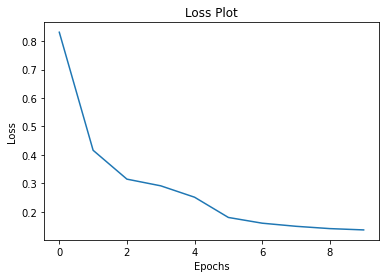

In [43]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Evaluate

In [44]:
from PIL import Image

In [45]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)
    
#     image = image.reshape([1] + list(raw_dataset.input_shape))    
#     temp_input = tf.expand_dims(image[0], 0)
#     img_tensor_val = image_features_extract_model(temp_input)
#     img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(image)

    dec_input = tf.expand_dims([0], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(voc.token_lookup[predicted_id])

        if voc.token_lookup[predicted_id] == '<END>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [46]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

#     fig = plt.figure(figsize=(20, 20))

    len_result = len(result)
    fig = plt.figure(figsize=(len_result*5, len_result*5))
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [47]:
eval_path = '../datasets/android/eval_set'

In [48]:
IMAGE_SIZE = 256

In [49]:
# Load caption annotation files and image files in Dataset
eval_raw_dataset = Dataset()
eval_raw_dataset.load(eval_path)

Loading data...
Generating sparse vectors...
Dataset size: 250
Vocabulary size: 20
Input shape: (256, 256, 3)
Output size: 20


In [50]:
def load_image(img):
# img = dataset.input_images[0]
    img = img.reshape([1] + list(eval_raw_dataset.input_shape))
    img_features = image_features_extract_model(img)
    img_features = tf.reshape(img_features,
(img_features.shape[0], -1, img_features.shape[3]))
    img_features = tf.squeeze(
    img_features, axis=None, name=None
)
    return img_features

ID: CF7CC084-6AEE-40EA-8C52-538F7273CEE1
Real Caption: <START> stack { 
 row { 
 radio 
 } 
 } 
 footer { 
 btn-notifications , btn-home , btn-search 
 } 
 <END>
Prediction Caption: stack { 
 row { 
 radio 
 } 
 } 
 footer { 
 btn-search , btn-home , btn-search 
 } 
 <END>


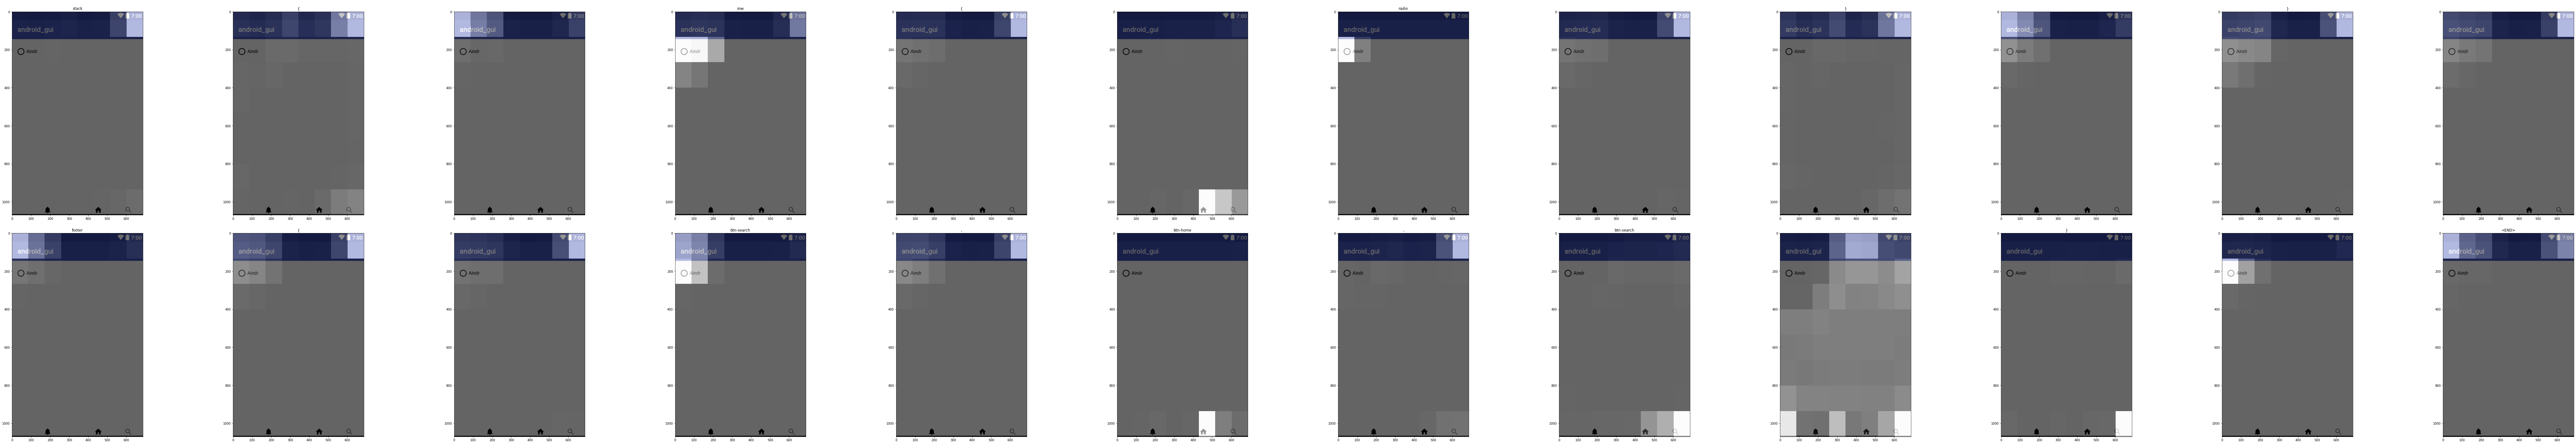

In [51]:
# captions on the validation set
rid = np.random.randint(0, eval_raw_dataset.size)

image = load_image(eval_raw_dataset.input_images[rid])
filename = eval_raw_dataset.ids[rid]
real_caption = ' '.join([eval_raw_dataset.voc.token_lookup[i] for i in eval_raw_dataset.total_sequences[rid]])
# real_caption = ' '.join(str(eval_raw_dataset.total_sequences[rid]))

result, attention_plot = evaluate(image)

print("ID: {}".format(filename))
print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
# print('Att plot: {}'.format(attention_plot*100))

# Image.open("{}/{}.png".format(eval_path,image_path))

plot_attention("{}/{}.png".format(eval_path, filename), result, attention_plot*100)